# LTV calculation on the sample data

The aim of the work is to calculate LTV of the first 30 days of users that entered the application in March. Below I will describe my approach on LTV calculation through Python code which allowed me to quickly estimate and visualize the results. At the same time this approach can be easily applied to data 10,000 times bigger than the current one. We would need to just implement several minor corrections.

Moreover it's possible to create one function using the code below to make the whole process even easier to be implemented every time we need it.

P.S it was interesting task, thank you!

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1BT53bQgzcNZOLYAPtuepwPKvqs1ETfIN"})
downloaded.GetContentFile('purchase_events.csv')

downloaded = drive.CreateFile({'id':"1bQibjaPvsQtS4fCRf6XRnnykTflqolyG"})
downloaded.GetContentFile('first_open_events.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_purchased = pd.read_csv('purchase_events.csv')
data_opened = pd.read_csv('first_open_events.csv')

In [ ]:
data_opened

,event_id,time,user_id,source,platform
0,1218,13/3/2021 10:45:10.909,AKwq-hiGEi4,NaN,NaN
1,1222,13/3/2021 11:03:28.349,T0dysjERPMX,NaN,NaN
2,1226,13/3/2021 11:19:44.418,k4TRAo2bF0q,NaN,NaN
3,1233,13/3/2021 12:18:56.061,Yg_XlFBrYsy,NaN,NaN
4,1257,13/3/2021 14:15:00.409,o5B2zv_KLZ,NaN,NaN
...,...,...,...,...,...
7196,7338,3/5/2021 18:01:52.819,sfgfiifggfgfsdsdsfdf12,NaN,NaN
7197,7339,7/5/2021 11:30:17.185,b0eaa5ad-2a14-4ab7-bfbf-c3901af6dad4,NaN,NaN
7198,7340,10/5/2021 08:24:37.529,00c96dec-527a-4c9a-ab20-aefed13538f8,NaN,NaN
7199,7341,10/5/2021 10:13:01.604,a43a74f6-d0c4-469b-8a23-9291d0829b9b,NaN,NaN


In [ ]:
data_opened['user_id'].value_counts()[data_opened['user_id'].value_counts() > 1]

aab6a07f-9eef-4e49-8697-d07dd9e2ff22     13
1i2saasdasdadasdasd                       6
b57e3bf8-c67b-45db-9861-6d940ec967ad      5
e0abfe18-0ab7-48a4-a536-c69b5f56d8aa      4
39c461a4-b091-47fe-b828-a9b7df9999ff      2
e1d2d1c7-5e1c-4b01-b6f1-58ed464c0e9d      2
21e003c6-08d0-4b54-93b3-9e9f13d5a834      2
fb2d19dc-8e0f-4f4d-b3fe-fc1530f57b11      2
1eb340ea-3f89-408a-852a-1a28ae7881c8      2
043c800a-834b-4a3c-89bd-fb803c9a1817      2
d882aabd-1caf-4842-9225-5cbc233e5cab      2
00c96dec-527a-4c9a-ab20-aefed13538f8      2
49bcad37-a81d-4279-bf6d-88cf6094ac0a      2
49bcad37-a81d-4279-bf6d-88cf6094ac0ab     2
49bcad37-a81d-4279-bf6d-88cf6094ac0b      2
26806092-f364-4331-b45f-f086ffa49557      2
Name: user_id, dtype: int64

Here we can clearly see that there is some problem with the dataset since there are for instance 13 inputs for a user with the same user_id to enter the application for the first time. Nevertheless, after observing those users we can see that all the events registered were in April and later so we can ignore those users for this task.

In [ ]:
data_opened.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7201 entries, 0 to 7200
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   event_id  7201 non-null   int64  
 1   time      7201 non-null   object 
 2   user_id   7201 non-null   object 
 3   source    0 non-null      float64
 4   platform  0 non-null      float64
dtypes: float64(2), int64(1), object(2)
memory usage: 281.4+ KB


We see that time variable is labeled as object type so in order to filter out only March month from the data we need to convert 'time' variable to datetime object. Afterwards we filter out only March month and determine which users did enter the app specifically in March.

In [ ]:
data_opened['time'] = pd.to_datetime(data_opened['time'])
data_purchased['time'] = pd.to_datetime(data_purchased['time'])

In [ ]:
data_opened = data_opened[data_opened["time"].dt.month == 3]

Now I merge this dataframe with dataframe that registers events whenever a user makes a purchase.

In [ ]:
merged_data = pd.merge(data_opened, data_purchased, on='user_id', how='left')

Determining which users did a purchase with positive value


In [ ]:
merged_data = merged_data.dropna(subset = ["valueUSD"])

In [ ]:
merged_data

,event_id_x,time_x,user_id,source_x,platform_x,event_id_y,time_y,sku,valueUSD,source_y,platform_y
10,1292,2021-03-13 17:21:24.098,VbXEGaiyId8,NaN,NaN,4738.0,2021-03-25 22:37:54.832,com.rockbite.testSKU,0.99,NaN,NaN
46,1532,2021-03-14 15:58:50.489,14PFw21TAt3,NaN,NaN,4038.0,2021-10-03 21:35:30.715,com.rockbite.testSKU,0.99,NaN,NaN
53,1613,2021-03-14 22:56:12.559,EuFxD1NIXMY,NaN,NaN,4768.0,2021-03-26 12:24:53.013,com.rockbite.testSKU,0.99,NaN,NaN
54,1616,2021-03-14 23:03:30.855,YrP9Xob4Q2,NaN,NaN,4979.0,2021-03-30 23:56:05.059,com.rockbite.testSKU,0.99,NaN,NaN
59,1671,2021-03-15 03:25:38.593,0N3aP8E19_n,NaN,NaN,4687.0,2021-03-24 19:34:14.191,com.rockbite.testSKU,1.99,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5738,5435,2021-03-28 03:23:28.805,hU-aS6CMKA,NaN,NaN,4828.0,2021-03-27 19:07:52.090,com.rockbite.testSKU,0.99,NaN,NaN
5739,5451,2021-03-28 04:41:23.678,-75L2aj2v-U,NaN,NaN,4032.0,2021-10-03 18:08:35.142,com.rockbite.testSKU,4.99,NaN,NaN
5745,5500,2021-03-28 08:00:26.244,Vsbogob43ug,NaN,NaN,4266.0,2021-03-15 15:30:22.894,com.rockbite.testSKU,8.99,NaN,NaN
5750,5550,2021-03-28 12:38:31.627,3_Q3lSoAN-T,NaN,NaN,4113.0,2021-12-03 12:22:43.876,com.rockbite.testSKU,0.99,NaN,NaN


Eliminating those users that did their purchase after 30 days since their first enter into the application.

In [ ]:
merged_data['difference'] = merged_data.time_y - merged_data.time_x
merged_data

,event_id_x,time_x,user_id,source_x,platform_x,event_id_y,time_y,sku,valueUSD,source_y,platform_y,difference
10,1292,2021-03-13 17:21:24.098,VbXEGaiyId8,NaN,NaN,4738.0,2021-03-25 22:37:54.832,com.rockbite.testSKU,0.99,NaN,NaN,12 days 05:16:30.734000
46,1532,2021-03-14 15:58:50.489,14PFw21TAt3,NaN,NaN,4038.0,2021-10-03 21:35:30.715,com.rockbite.testSKU,0.99,NaN,NaN,203 days 05:36:40.226000
53,1613,2021-03-14 22:56:12.559,EuFxD1NIXMY,NaN,NaN,4768.0,2021-03-26 12:24:53.013,com.rockbite.testSKU,0.99,NaN,NaN,11 days 13:28:40.454000
54,1616,2021-03-14 23:03:30.855,YrP9Xob4Q2,NaN,NaN,4979.0,2021-03-30 23:56:05.059,com.rockbite.testSKU,0.99,NaN,NaN,16 days 00:52:34.204000
59,1671,2021-03-15 03:25:38.593,0N3aP8E19_n,NaN,NaN,4687.0,2021-03-24 19:34:14.191,com.rockbite.testSKU,1.99,NaN,NaN,9 days 16:08:35.598000
...,...,...,...,...,...,...,...,...,...,...,...,...
5738,5435,2021-03-28 03:23:28.805,hU-aS6CMKA,NaN,NaN,4828.0,2021-03-27 19:07:52.090,com.rockbite.testSKU,0.99,NaN,NaN,-1 days +15:44:23.285000
5739,5451,2021-03-28 04:41:23.678,-75L2aj2v-U,NaN,NaN,4032.0,2021-10-03 18:08:35.142,com.rockbite.testSKU,4.99,NaN,NaN,189 days 13:27:11.464000
5745,5500,2021-03-28 08:00:26.244,Vsbogob43ug,NaN,NaN,4266.0,2021-03-15 15:30:22.894,com.rockbite.testSKU,8.99,NaN,NaN,-13 days +07:29:56.650000
5750,5550,2021-03-28 12:38:31.627,3_Q3lSoAN-T,NaN,NaN,4113.0,2021-12-03 12:22:43.876,com.rockbite.testSKU,0.99,NaN,NaN,249 days 23:44:12.249000


We can see here that there are negative values meaning that there is presumably a problem with the analytical tool since it register the first entry after first purchase which is not very logical. To be able to calculate LTV and for this task only (since I do not have direct communication with marketing team) I will consider absolute of the values.

Moreover let's also filter out those users with difference of max 30 days from period of entering the app and registering the first purchase.

In [ ]:
merged_data = merged_data[merged_data['difference'].dt.days <= 30]
merged_data

,event_id_x,time_x,user_id,source_x,platform_x,event_id_y,time_y,sku,valueUSD,source_y,platform_y,difference
10,1292,2021-03-13 17:21:24.098,VbXEGaiyId8,NaN,NaN,4738.0,2021-03-25 22:37:54.832,com.rockbite.testSKU,0.99,NaN,NaN,12 days 05:16:30.734000
53,1613,2021-03-14 22:56:12.559,EuFxD1NIXMY,NaN,NaN,4768.0,2021-03-26 12:24:53.013,com.rockbite.testSKU,0.99,NaN,NaN,11 days 13:28:40.454000
54,1616,2021-03-14 23:03:30.855,YrP9Xob4Q2,NaN,NaN,4979.0,2021-03-30 23:56:05.059,com.rockbite.testSKU,0.99,NaN,NaN,16 days 00:52:34.204000
59,1671,2021-03-15 03:25:38.593,0N3aP8E19_n,NaN,NaN,4687.0,2021-03-24 19:34:14.191,com.rockbite.testSKU,1.99,NaN,NaN,9 days 16:08:35.598000
61,1701,2021-03-15 05:42:11.287,bDvDobgFM5t,NaN,NaN,4945.0,2021-03-30 06:07:42.008,com.rockbite.testSKU,1.99,NaN,NaN,15 days 00:25:30.721000
...,...,...,...,...,...,...,...,...,...,...,...,...
5716,5199,2021-03-27 07:07:50.117,C6NdRb0q8rU,NaN,NaN,4243.0,2021-03-15 04:31:33.663,com.rockbite.testSKU,0.99,NaN,NaN,-13 days +21:23:43.546000
5717,5199,2021-03-27 07:07:50.117,C6NdRb0q8rU,NaN,NaN,4766.0,2021-03-26 11:10:13.094,com.rockbite.testSKU,0.99,NaN,NaN,-1 days +04:02:22.977000
5738,5435,2021-03-28 03:23:28.805,hU-aS6CMKA,NaN,NaN,4828.0,2021-03-27 19:07:52.090,com.rockbite.testSKU,0.99,NaN,NaN,-1 days +15:44:23.285000
5745,5500,2021-03-28 08:00:26.244,Vsbogob43ug,NaN,NaN,4266.0,2021-03-15 15:30:22.894,com.rockbite.testSKU,8.99,NaN,NaN,-13 days +07:29:56.650000


In [ ]:
merged_data['difference'] = abs(merged_data['difference'].dt.days)
merged_data['valueUSD'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0.99    344
1.99    162
4.99     99
8.99     84
Name: valueUSD, dtype: int64

Creating a table with days as column names and purchase amount as values within the table. Furthermore let's denote all the other values as 0. 

In [ ]:
merged_data_1 = merged_data.pivot_table(values='valueUSD', index= 'user_id', columns='difference', aggfunc='first').copy()

In [ ]:
merged_data_1.fillna(0, inplace =True)
merged_data_1

difference,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
user_id,,,,,,,,,,,,,,,,,,,,
-41MEySy9_Q,0.00,0.00,0.0,0.0,0.00,4.99,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
-Gg1lRRUbq,0.00,0.00,0.0,0.0,0.99,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
-Qj2aH-dMli,0.00,0.00,0.0,0.0,0.00,0.00,0.0,1.99,0.0,0.00,1.99,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0
-RcScBC7g9U,0.00,4.99,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
-U-YHcnRfh,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.99,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zXr00t0mb7,0.00,0.99,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
zkCrn7byni,0.00,0.00,0.0,0.0,1.99,0.00,0.0,0.00,0.0,0.00,0.99,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
zmXlr1vCzUx,0.99,0.00,0.0,0.0,0.00,4.99,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0


Prolonging the table for 30 days and assigning 0 as no purchase was done during that prolonged period of time.

In [ ]:
for i in range(20,31):
  merged_data_1[i] = 0.00

In [ ]:
merged_data_1

difference,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-41MEySy9_Q,0.00,0.00,0.0,0.0,0.00,4.99,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Gg1lRRUbq,0.00,0.00,0.0,0.0,0.99,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-Qj2aH-dMli,0.00,0.00,0.0,0.0,0.00,0.00,0.0,1.99,0.0,0.00,1.99,0.0,0.0,0.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-RcScBC7g9U,0.00,4.99,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-U-YHcnRfh,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.99,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zXr00t0mb7,0.00,0.99,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zkCrn7byni,0.00,0.00,0.0,0.0,1.99,0.00,0.0,0.00,0.0,0.00,0.99,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zmXlr1vCzUx,0.99,0.00,0.0,0.0,0.00,4.99,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Creating a copy of the pivot table to continue our transformations.

In [ ]:
pivot = merged_data_1.copy()

Creating cumulative sums of the rows.

In [ ]:
pivot=pivot.cumsum(axis = 1)
pivot

difference,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-41MEySy9_Q,0.00,0.00,0.00,0.00,0.00,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99
-Gg1lRRUbq,0.00,0.00,0.00,0.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
-Qj2aH-dMli,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.99,1.99,1.99,3.98,3.98,3.98,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97,4.97
-RcScBC7g9U,0.00,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99,4.99
-U-YHcnRfh,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zXr00t0mb7,0.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
zkCrn7byni,0.00,0.00,0.00,0.00,1.99,1.99,1.99,1.99,1.99,1.99,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98,2.98
zmXlr1vCzUx,0.99,0.99,0.99,0.99,0.99,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98,5.98


Deviding the amounts with the number of all users to sum them up and receive LTV.

In [ ]:
LTV = pivot / len(data_opened.index)

In [ ]:
LTV_Final = LTV.sum().copy()
LTV_Final

difference
0     0.019335
1     0.054383
2     0.080566
3     0.103505
4     0.136947
5     0.170194
6     0.196390
7     0.218067
8     0.235398
9     0.256180
10    0.274617
11    0.282375
12    0.292669
13    0.303159
14    0.313097
15    0.317434
16    0.323030
17    0.327367
18    0.330078
19    0.330257
20    0.330257
21    0.330257
22    0.330257
23    0.330257
24    0.330257
25    0.330257
26    0.330257
27    0.330257
28    0.330257
29    0.330257
30    0.330257
dtype: float64

Creating LTV chart for users that entered for the first time in March.

Text(0.5, 1.0, 'LTV of users from March')

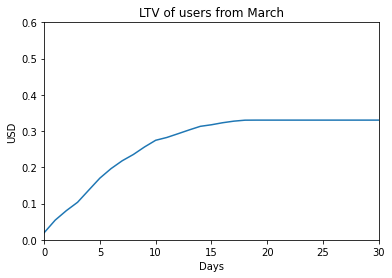

In [ ]:
plt.plot(LTV_Final)
plt.ylim(0,0.6)
plt.xlim(0,30)
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('LTV of users from March')